In [17]:
import os
import random
import re
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def load_images_from_all(model_folders, specific_folder ="all", order=2):
    """
    Load the n-th ordered image from the 'all' folder inside each model folder.
    Assumes a consistent directory structure.
    
    Parameters:
    - model_folders: List of model folders.
    - order: The n-th index of the sorted images to pick (default: 2).
    """
    images = []
    for folder in model_folders:
        all_folder = os.path.join(folder, specific_folder)
        # Get all image files in the "all" folder
        image_files = sorted([f for f in os.listdir(all_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])
        
        if image_files:
            if 0 <= order < len(image_files):  # Check if the order index is valid
                selected_image = image_files[order]
            else:
                raise IndexError(f"Order {order} is out of range for the available files in {all_folder}")
            images.append(os.path.join(all_folder, selected_image))
        else:
            raise FileNotFoundError(f"No images found in {all_folder}")
    print(f"Model images loaded: {images}")  # Log the model paths
    return images

def get_nth_image_from_directory(directory, order=2):
    """
    Select the n-th ordered image from a directory.
    """
    image_files = sorted([f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))])
    if image_files:
        if 0 <= order < len(image_files):  # Check if the order index is valid
            selected_image_path = os.path.join(directory, image_files[order])
            print(f"Selected image from {directory}: {selected_image_path}")  # Log the path
            return selected_image_path
        else:
            raise IndexError(f"Order {order} is out of range for the available files in {directory}")
    else:
        raise FileNotFoundError(f"No images found in {directory}")

def resize_image(image, target_size=(1280, 720)):
    """
    Resize an image to the specified target size.
    """
    return image.resize(target_size, Image.ANTIALIAS)

def get_random_zoom_coords(image_size, box_size=100):
    """
    Generate random coordinates for a zoom box within the image boundaries.
    """
    width, height = image_size
    x1 = random.randint(0, width - box_size)
    y1 = random.randint(0, height - box_size)
    x2 = x1 + box_size
    y2 = y1 + box_size
    zoom_coords = (x1, y1, x2, y2)
    print(f"Random zoom coordinates: {zoom_coords}")  # Log the zoom coordinates
    return zoom_coords

def extract_psnr_from_filename(filename):
    """
    Extract the PSNR value from the filename using regex.
    """
    match = re.search(r'PSNR([\d\.]+)', filename)
    psnr_value = f"PSNR: {match.group(1)}" if match else "PSNR: N/A"
    print(f"Extracted PSNR from {filename}: {psnr_value}")  # Log the PSNR
    return psnr_value

# Example usage
base_dir = "results/motion/testuhdm"
model_folders = [
    os.path.join(base_dir, "best_new_model_testuhdm"),
    os.path.join(base_dir, "finetunedwithJ_testuhdm"),
    os.path.join(base_dir, "finetunedwithR_testuhdm"),
    os.path.join(base_dir, "motion_deblurring_testuhdm"),
    os.path.join(base_dir, "trained_from_scratch_testuhdm"),
]

model_names = [
    "Improved Model",
    "Finetuned with RealBlurJ",
    "Finetuned with RealBlurR",
    "Model checkpoint",
    "Reproduced Model",
]


In [3]:
def save_plot(fig, output_dir, file_name):
    """
    Save a Matplotlib figure to the specified directory with the given file name.
    
    Parameters:
    - fig: Matplotlib figure object to save.
    - output_dir: Directory where the figure should be saved.
    - file_name: Name of the output file.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
    output_path = os.path.join(output_dir, file_name)
    fig.savefig(output_path, dpi=300)
    print(f"Figure saved at: {output_path}")

def plot_deblurring_comparison(
    blurry_path, reference_path, model_paths, model_names, target_size=(1280, 720), box_size=100,
    dataset_name="testuhdm", specific_folder="good", output_base_dir="report_visuals", hspace=0.2, wspace=0.2
):
    """
    Parameters:
    - blurry_path: Path to the blurry image
    - reference_path: Path to the reference image
    - model_paths: List of paths to images generated by models
    - model_names: List of model names
    - target_size: Tuple for resizing all images
    - box_size: Size of the zoom box (square)
    - output_base_dir: Base directory for saving output visuals
    - dataset_name: Name of the dataset
    - specific_folder: Folder name inside the dataset
    """
    assert len(model_paths) == len(model_names), "Number of models and paths must match."

    # Log input paths
    print(f"Blurry image path: {blurry_path}")
    print(f"Reference image path: {reference_path}")

    # Load and resize images
    blurry = resize_image(Image.open(blurry_path), target_size)
    reference = resize_image(Image.open(reference_path), target_size)
    model_images = [resize_image(Image.open(path), target_size) for path in model_paths]

    # Generate random zoom coordinates
    zoom_coords = get_random_zoom_coords(target_size, box_size)

    # Mark the zoom region on the full images
    marked_images = []
    for img in [blurry, reference, *model_images]:
        img_copy = img.copy()
        draw = ImageDraw.Draw(img_copy)
        draw.rectangle(zoom_coords, outline="red", width=5)
        marked_images.append(img_copy)

    # Extract zoomed patches
    patches = [img.crop(zoom_coords) for img in [blurry, reference, *model_images]]

    # Create combined plot
    total_columns = len(model_paths) + 2  # Blurry + Reference + Models
    fig, ax = plt.subplots(2, total_columns, figsize=(20, 12))

    # Plot full images with marked zoom region
    ax[0, 0].imshow(marked_images[0])
    ax[0, 0].set_title("Blurry Image", fontsize=10)
    ax[0, 1].imshow(marked_images[1])
    ax[0, 1].set_title("Reference Image", fontsize=10)
    for i, (img, name) in enumerate(zip(marked_images[2:], model_names)):
        ax[0, i + 2].imshow(img)
        ax[0, i + 2].set_title(f"{name}", fontsize=10)

    # Plot zoomed patches with PSNR in captions
    ax[1, 0].imshow(patches[0])
    ax[1, 0].set_title("Blurry Patch", fontsize=10)
    ax[1, 1].imshow(patches[1])
    ax[1, 1].set_title("Reference Patch", fontsize=10)
    for i, (patch, path) in enumerate(zip(patches[2:], model_paths)):
        psnr = extract_psnr_from_filename(os.path.basename(path))
        ax[1, i + 2].imshow(patch)
        ax[1, i + 2].set_title(f"{model_names[i]}\n{psnr}", fontsize=10)

    # Turn off axes
    for row in ax:
        for cell in row:
            cell.axis("off")

    plt.subplots_adjust(hspace=hspace)  # Adjust vertical spacing (reduce as needed)
    plt.subplots_adjust(wspace=wspace)  # Adjust horizontal spacing (reduce as needed)
    plt.tight_layout()

    # Save combined plot
    image_basename = os.path.splitext(os.path.basename(blurry_path))[0]
    save_plot(fig, os.path.join(output_base_dir, dataset_name, specific_folder), f"{image_basename}_combined.png")
    plt.show()


ALL

Selected image from dataset/motion/testuhdm/blurry: dataset/motion/testuhdm/blurry/6_ours_20200903IMG_1147_t1_151.png
Selected image from dataset/motion/testuhdm/sharp: dataset/motion/testuhdm/sharp/6_ours_20200903IMG_1147_151.png
Model images loaded: ['results/motion/testuhdm/best_new_model_testuhdm/all/6_ours_20200903IMG_1147_t1_171_PSNR17.53_SSIM0.40_MAE0.10_LPIPS0.53_DeltaE6.14.png', 'results/motion/testuhdm/finetunedwithJ_testuhdm/all/6_ours_20200903IMG_1147_t1_171_PSNR16.97_SSIM0.36_MAE0.11_LPIPS0.57_DeltaE6.86.png', 'results/motion/testuhdm/finetunedwithR_testuhdm/all/6_ours_20200903IMG_1147_t1_171_PSNR17.31_SSIM0.35_MAE0.10_LPIPS0.59_DeltaE6.32.png', 'results/motion/testuhdm/motion_deblurring_testuhdm/all/6_ours_20200903IMG_1147_t1_171_PSNR16.58_SSIM0.30_MAE0.11_LPIPS0.67_DeltaE5.89.png', 'results/motion/testuhdm/trained_from_scratch_testuhdm/all/6_ours_20200903IMG_1147_t1_171_PSNR17.19_SSIM0.35_MAE0.11_LPIPS0.60_DeltaE6.10.png']
Blurry image path: dataset/motion/testuhdm/blurr

/home/user1/miniconda3/envs/pytorch181/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.


Random zoom coordinates: (506, 404, 606, 504)
Extracted PSNR from 6_ours_20200903IMG_1147_t1_171_PSNR17.53_SSIM0.40_MAE0.10_LPIPS0.53_DeltaE6.14.png: PSNR: 17.53
Extracted PSNR from 6_ours_20200903IMG_1147_t1_171_PSNR16.97_SSIM0.36_MAE0.11_LPIPS0.57_DeltaE6.86.png: PSNR: 16.97
Extracted PSNR from 6_ours_20200903IMG_1147_t1_171_PSNR17.31_SSIM0.35_MAE0.10_LPIPS0.59_DeltaE6.32.png: PSNR: 17.31
Extracted PSNR from 6_ours_20200903IMG_1147_t1_171_PSNR16.58_SSIM0.30_MAE0.11_LPIPS0.67_DeltaE5.89.png: PSNR: 16.58
Extracted PSNR from 6_ours_20200903IMG_1147_t1_171_PSNR17.19_SSIM0.35_MAE0.11_LPIPS0.60_DeltaE6.10.png: PSNR: 17.19
Figure saved at: report_visuals/testuhdm/all/6_ours_20200903IMG_1147_t1_151_combined.png


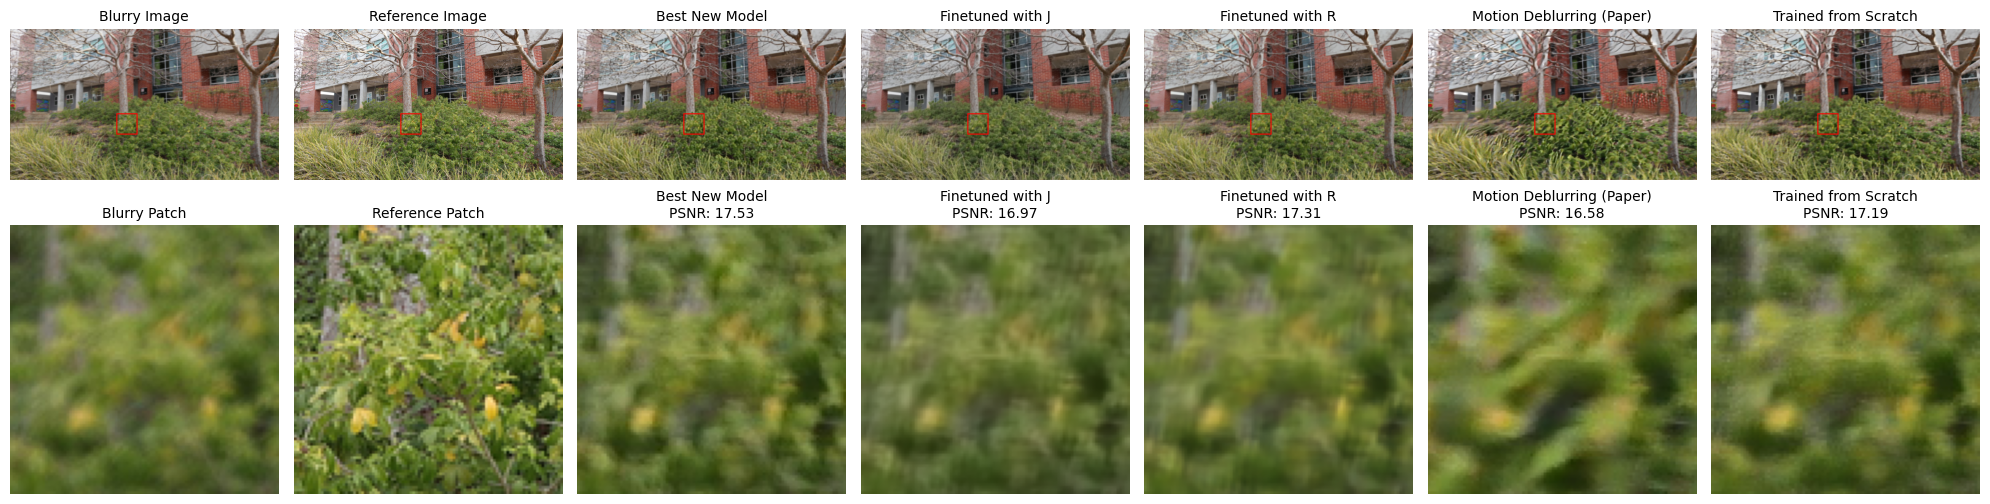

In [175]:

offset = 5
index = 2
blurry_path = get_nth_image_from_directory("dataset/motion/testuhdm/blurry", order=(index + (index * offset)))
reference_path = get_nth_image_from_directory("dataset/motion/testuhdm/sharp", order=(index + (index * offset)))
model_paths = load_images_from_all(model_folders, specific_folder="all", order=index)

plot_deblurring_comparison(blurry_path, reference_path, model_paths, model_names,dataset_name="testuhdm", specific_folder="all"
                           , hspace=-0.95, wspace=0.02)


Good

Model images loaded: ['results/motion/testuhdm/best_new_model_testuhdm/good/IMG_1649_t1_171_PSNR32.84_SSIM0.92_MAE0.02_LPIPS0.07_DeltaE2.02.png', 'results/motion/testuhdm/finetunedwithJ_testuhdm/good/IMG_1649_t1_171_PSNR32.56_SSIM0.93_MAE0.01_LPIPS0.14_DeltaE2.85.png', 'results/motion/testuhdm/finetunedwithR_testuhdm/good/IMG_1649_t1_171_PSNR34.03_SSIM0.94_MAE0.01_LPIPS0.14_DeltaE2.20.png', 'results/motion/testuhdm/motion_deblurring_testuhdm/good/IMG_1649_t1_171_PSNR32.06_SSIM0.92_MAE0.02_LPIPS0.11_DeltaE2.27.png', 'results/motion/testuhdm/trained_from_scratch_testuhdm/good/IMG_1649_t1_171_PSNR32.14_SSIM0.91_MAE0.02_LPIPS0.11_DeltaE2.55.png']
Blurry image path: dataset/motion/testuhdm/blurry/IMG_1649_t1_171.png
Reference image path: dataset/motion/testuhdm/sharp/IMG_1649_171.png


/home/user1/miniconda3/envs/pytorch181/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.


Random zoom coordinates: (633, 276, 733, 376)
Extracted PSNR from IMG_1649_t1_171_PSNR32.84_SSIM0.92_MAE0.02_LPIPS0.07_DeltaE2.02.png: PSNR: 32.84
Extracted PSNR from IMG_1649_t1_171_PSNR32.56_SSIM0.93_MAE0.01_LPIPS0.14_DeltaE2.85.png: PSNR: 32.56
Extracted PSNR from IMG_1649_t1_171_PSNR34.03_SSIM0.94_MAE0.01_LPIPS0.14_DeltaE2.20.png: PSNR: 34.03
Extracted PSNR from IMG_1649_t1_171_PSNR32.06_SSIM0.92_MAE0.02_LPIPS0.11_DeltaE2.27.png: PSNR: 32.06
Extracted PSNR from IMG_1649_t1_171_PSNR32.14_SSIM0.91_MAE0.02_LPIPS0.11_DeltaE2.55.png: PSNR: 32.14
Figure saved at: report_visuals/testuhdm/good/IMG_1649_t1_171_combined.png


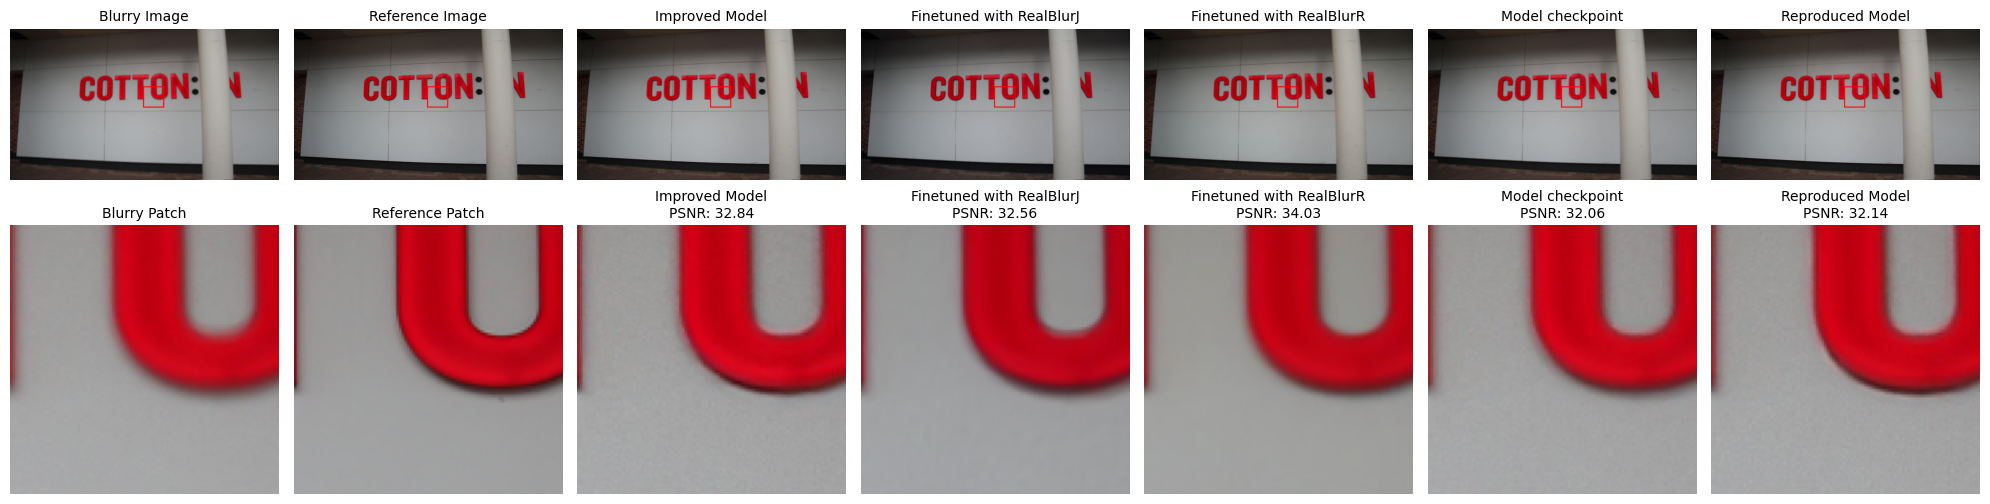

In [39]:

index = 0
blurry_path = "dataset/motion/testuhdm/blurry/IMG_1649_t1_171.png"
reference_path = "dataset/motion/testuhdm/sharp/IMG_1649_171.png"
model_paths = load_images_from_all(model_folders, specific_folder="good", order=index)

plot_deblurring_comparison(blurry_path, reference_path, model_paths, model_names,dataset_name="testuhdm", specific_folder="good"
                           , hspace=-0.95, wspace=0.02)


Bad

Model images loaded: ['results/motion/testuhdm/best_new_model_testuhdm/bad/6_ours_20200903IMG_1148_t1_171_PSNR18.21_SSIM0.46_MAE0.09_LPIPS0.45_DeltaE4.65.png', 'results/motion/testuhdm/finetunedwithJ_testuhdm/bad/6_ours_20200903IMG_1148_t1_171_PSNR16.80_SSIM0.38_MAE0.11_LPIPS0.48_DeltaE5.01.png', 'results/motion/testuhdm/finetunedwithR_testuhdm/bad/6_ours_20200903IMG_1148_t1_171_PSNR17.22_SSIM0.40_MAE0.10_LPIPS0.54_DeltaE5.59.png', 'results/motion/testuhdm/motion_deblurring_testuhdm/bad/6_ours_20200903IMG_1148_t1_171_PSNR17.89_SSIM0.41_MAE0.09_LPIPS0.59_DeltaE5.32.png', 'results/motion/testuhdm/trained_from_scratch_testuhdm/bad/6_ours_20200903IMG_1148_t1_171_PSNR17.87_SSIM0.42_MAE0.09_LPIPS0.57_DeltaE3.33.png']
Blurry image path: dataset/motion/testuhdm/blurry/6_ours_20200903IMG_1148_t1_171.png
Reference image path: dataset/motion/testuhdm/sharp/6_ours_20200903IMG_1148_171.png


/home/user1/miniconda3/envs/pytorch181/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.


Random zoom coordinates: (1164, 203, 1264, 303)
Extracted PSNR from 6_ours_20200903IMG_1148_t1_171_PSNR18.21_SSIM0.46_MAE0.09_LPIPS0.45_DeltaE4.65.png: PSNR: 18.21
Extracted PSNR from 6_ours_20200903IMG_1148_t1_171_PSNR16.80_SSIM0.38_MAE0.11_LPIPS0.48_DeltaE5.01.png: PSNR: 16.80
Extracted PSNR from 6_ours_20200903IMG_1148_t1_171_PSNR17.22_SSIM0.40_MAE0.10_LPIPS0.54_DeltaE5.59.png: PSNR: 17.22
Extracted PSNR from 6_ours_20200903IMG_1148_t1_171_PSNR17.89_SSIM0.41_MAE0.09_LPIPS0.59_DeltaE5.32.png: PSNR: 17.89
Extracted PSNR from 6_ours_20200903IMG_1148_t1_171_PSNR17.87_SSIM0.42_MAE0.09_LPIPS0.57_DeltaE3.33.png: PSNR: 17.87
Figure saved at: report_visuals/testuhdm/bad/6_ours_20200903IMG_1148_t1_171_combined.png


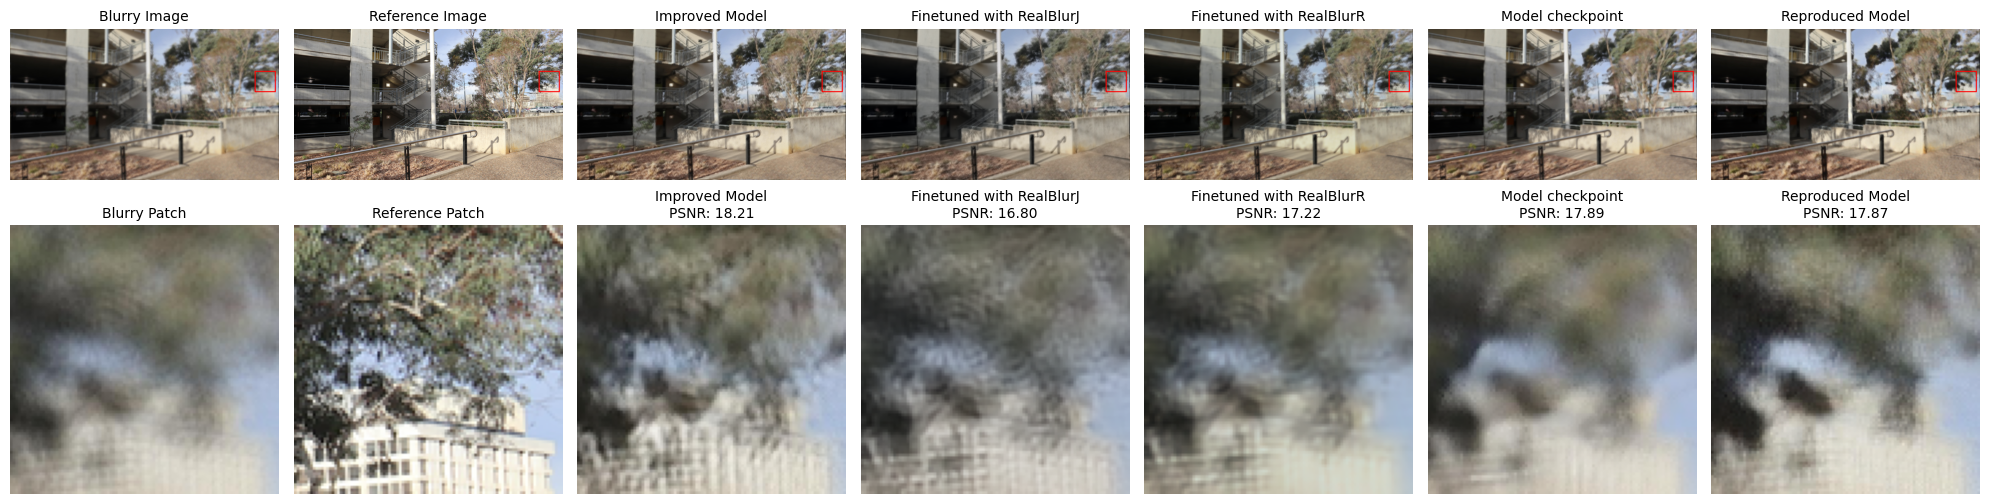

In [40]:

index = 2
blurry_path = "dataset/motion/testuhdm/blurry/6_ours_20200903IMG_1148_t1_171.png"
reference_path = "dataset/motion/testuhdm/sharp/6_ours_20200903IMG_1148_171.png"
model_paths = load_images_from_all(model_folders, specific_folder="bad", order=index)

plot_deblurring_comparison(blurry_path, reference_path, model_paths, model_names,dataset_name="testuhdm", specific_folder="bad"
                           , hspace=-0.95, wspace=0.02)


testrealblur/RealBlur-J

Model images loaded: ['results/motion/testrealblur/RealBlur-J/best_new_model_RealBlur-J/good/blur_260_PSNR30.38_SSIM0.92_MAE0.02_LPIPS0.06_DeltaE2.74.png', 'results/motion/testrealblur/RealBlur-J/finetunedwithJ_RealBlur-J/good/blur_260_PSNR32.17_SSIM0.94_MAE0.02_LPIPS0.04_DeltaE1.36.png', 'results/motion/testrealblur/RealBlur-J/motion_deblurring_RealBlur-J/good/blur_260_PSNR30.30_SSIM0.91_MAE0.02_LPIPS0.06_DeltaE2.72.png', 'results/motion/testrealblur/RealBlur-J/trained_from_scratch_RealBlur-J/good/blur_260_PSNR30.28_SSIM0.91_MAE0.02_LPIPS0.06_DeltaE2.74.png']
Blurry image path: dataset/motion/testrealblur/RealBlur-J/input/blur_260.png
Reference image path: dataset/motion/testrealblur/RealBlur-J/target/gt_260.png
Random zoom coordinates: (107, 635, 207, 735)


/home/user1/miniconda3/envs/pytorch181/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.


Extracted PSNR from blur_260_PSNR30.38_SSIM0.92_MAE0.02_LPIPS0.06_DeltaE2.74.png: PSNR: 30.38
Extracted PSNR from blur_260_PSNR32.17_SSIM0.94_MAE0.02_LPIPS0.04_DeltaE1.36.png: PSNR: 32.17
Extracted PSNR from blur_260_PSNR30.30_SSIM0.91_MAE0.02_LPIPS0.06_DeltaE2.72.png: PSNR: 30.30
Extracted PSNR from blur_260_PSNR30.28_SSIM0.91_MAE0.02_LPIPS0.06_DeltaE2.74.png: PSNR: 30.28
Figure saved at: report_visuals/testrealblur-J/good/blur_260_combined.png


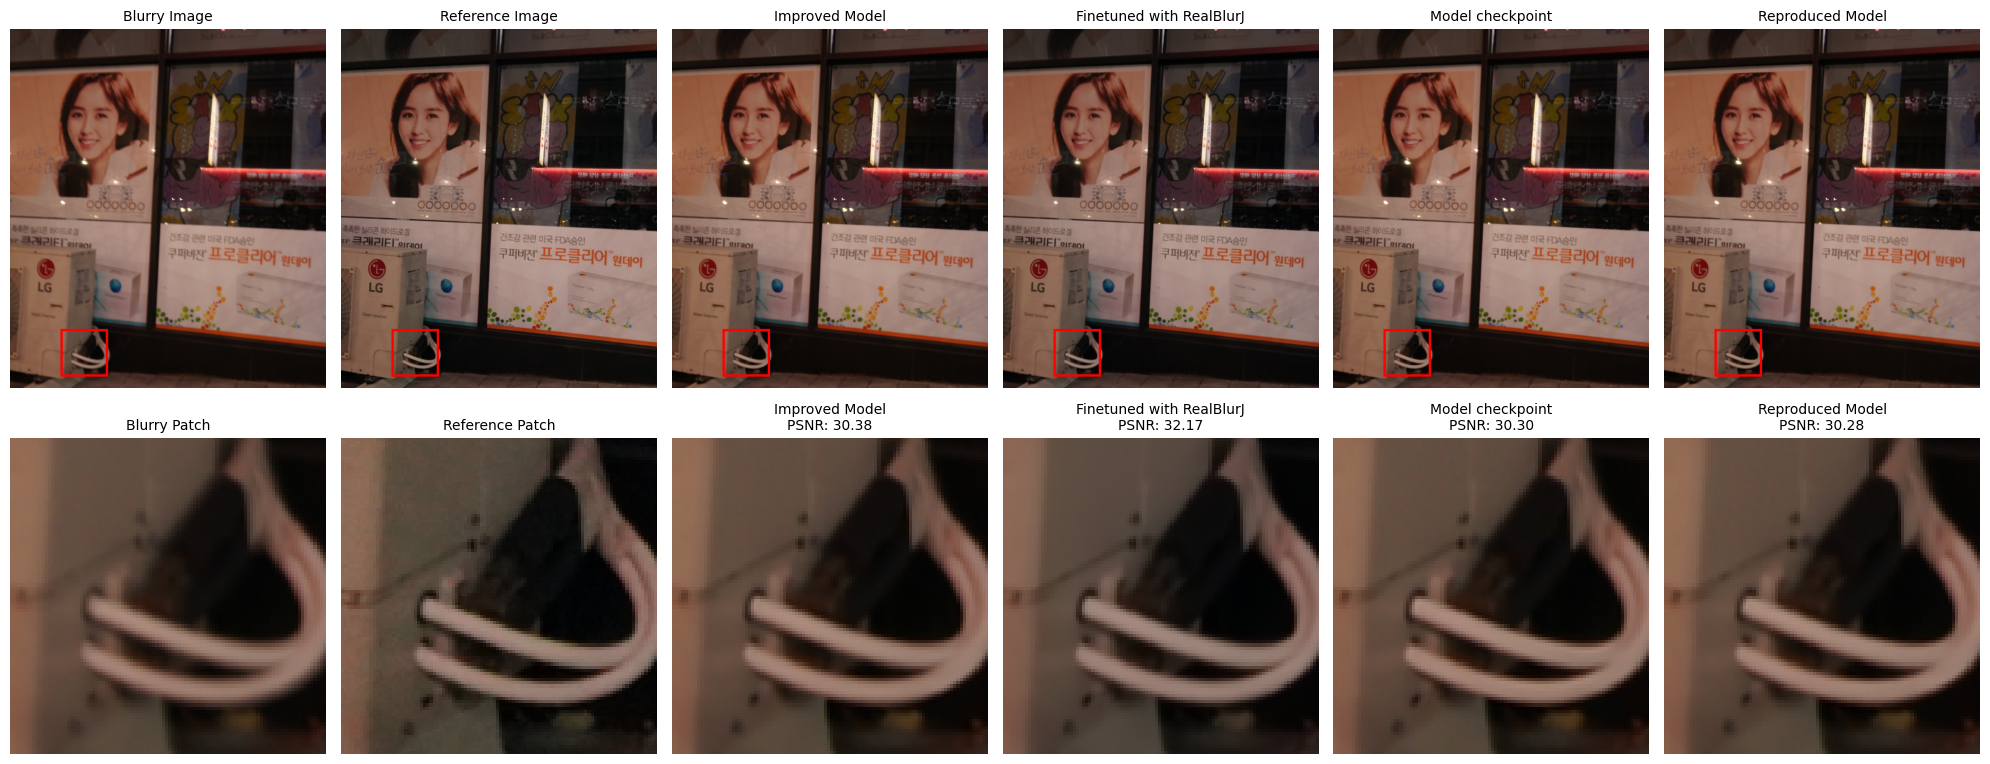

In [16]:
def load_images_by_name(model_folders, specific_folder="all", image_name="blur_26.png"):
    """
    Load an image by its substring (e.g., base name without metrics) from the corresponding directories.

    Parameters:
    - model_folders: List of model folders.
    - specific_folder: Subfolder within the model folder to search (default: "all").
    - image_name: Substring of the image to find (e.g., "blur_26.png").
    
    Returns:
    - List of full paths to the images found in the corresponding folders.
    """
    # Remove file extension for substring matching
    search_name = os.path.splitext(image_name)[0]  # e.g., 'blur_26' from 'blur_26.png'

    images = []
    for folder in model_folders:
        target_folder = os.path.join(folder, specific_folder)
        if not os.path.exists(target_folder):
            raise FileNotFoundError(f"Folder not found: {target_folder}")

        # Get all image files in the target folder
        image_files = [f for f in os.listdir(target_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

        # Search for the image name as a substring in the file names
        matching_images = [f for f in image_files if search_name in f]
        if matching_images:
            # Select the first matching image (or apply custom logic if multiple matches occur)
            selected_image = matching_images[0]
            images.append(os.path.join(target_folder, selected_image))
        else:
            raise FileNotFoundError(f"No matching images found for '{search_name}' in {target_folder}")
    
    print(f"Model images loaded: {images}")  # Log the model paths
    return images

base_dir = "results/motion/testrealblur/RealBlur-J"
model_folders = [
    os.path.join(base_dir, "best_new_model_RealBlur-J"),
    os.path.join(base_dir, "finetunedwithJ_RealBlur-J"),
    os.path.join(base_dir, "motion_deblurring_RealBlur-J"),
    os.path.join(base_dir, "trained_from_scratch_RealBlur-J"),
]

model_names = [
    "Improved Model",
    "Finetuned with RealBlurJ",
    "Model checkpoint",
    "Reproduced Model",
]

specific_folder = "good"
number = "260"
image_name = "blur_"+number+".png"  # Image name with extension (only the base name is used for matching)
dataset_name = "testrealblur-J"

blurry_path = "dataset/motion/testrealblur/RealBlur-J/input/blur_"+number+".png"
reference_path = "dataset/motion/testrealblur/RealBlur-J/target/gt_"+number+".png"

# Load model images by name
model_paths = load_images_by_name(model_folders, specific_folder=specific_folder, image_name=image_name)

# Plot comparison
plot_deblurring_comparison(
    blurry_path, reference_path, model_paths, model_names,
    target_size=(670, 760), dataset_name=dataset_name, specific_folder=specific_folder,
    hspace=-0.71, wspace=0.02
)


testrealblur/RealBlur-R

Model images loaded: ['results/motion/testrealblur/RealBlur-R/best_new_model_RealBlur-R/bad/blur_830_PSNR17.38_SSIM0.65_MAE0.05_LPIPS0.23_DeltaE1.14.png', 'results/motion/testrealblur/RealBlur-R/finetunedwithR_RealBlur-R/bad/blur_830_PSNR18.44_SSIM0.69_MAE0.04_LPIPS0.15_DeltaE0.70.png', 'results/motion/testrealblur/RealBlur-R/motion_deblurring_RealBlur-R/bad/blur_830_PSNR17.40_SSIM0.65_MAE0.05_LPIPS0.23_DeltaE1.10.png', 'results/motion/testrealblur/RealBlur-R/trained_from_scratch_RealBlur-R/bad/blur_830_PSNR17.43_SSIM0.66_MAE0.05_LPIPS0.24_DeltaE1.10.png']
Blurry image path: dataset/motion/testrealblur/RealBlur-R/input/blur_830.png
Reference image path: dataset/motion/testrealblur/RealBlur-R/target/gt_830.png
Random zoom coordinates: (525, 234, 625, 334)
Extracted PSNR from blur_830_PSNR17.38_SSIM0.65_MAE0.05_LPIPS0.23_DeltaE1.14.png: PSNR: 17.38
Extracted PSNR from blur_830_PSNR18.44_SSIM0.69_MAE0.04_LPIPS0.15_DeltaE0.70.png: PSNR: 18.44
Extracted PSNR from blur_830_PSNR17.40_SSIM0.65

/home/user1/miniconda3/envs/pytorch181/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.


Figure saved at: report_visuals/testrealblur-R/bad/blur_830_combined.png


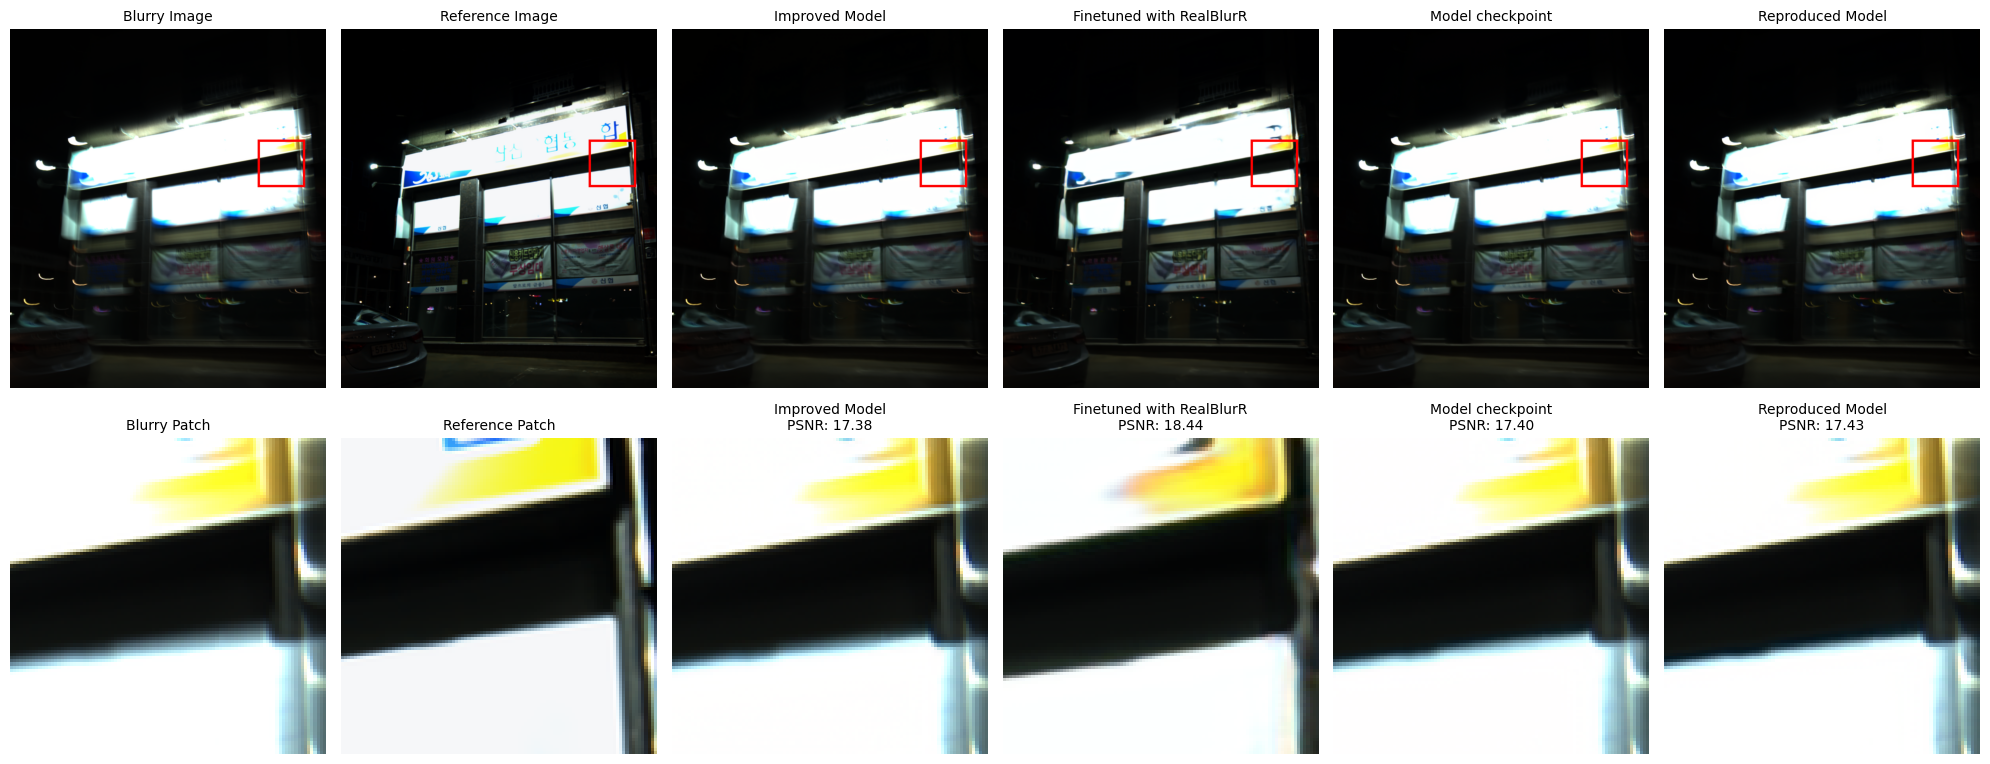

In [43]:

base_dir = "results/motion/testrealblur/RealBlur-R"
model_folders = [
    os.path.join(base_dir, "best_new_model_RealBlur-R"),
    os.path.join(base_dir, "finetunedwithR_RealBlur-R"),
    os.path.join(base_dir, "motion_deblurring_RealBlur-R"),
    os.path.join(base_dir, "trained_from_scratch_RealBlur-R"),
]

model_names = [
    "Improved Model",
    "Finetuned with RealBlurR",
    "Model checkpoint",
    "Reproduced Model",
]

specific_folder = "bad"
number = "830"
image_name = "blur_"+number+".png"  # Image name with extension (only the base name is used for matching)
dataset_name = "testrealblur-R"

blurry_path = "dataset/motion/testrealblur/RealBlur-R/input/blur_"+number+".png"
reference_path = "dataset/motion/testrealblur/RealBlur-R/target/gt_"+number+".png"

# Load model images by name
model_paths = load_images_by_name(model_folders, specific_folder=specific_folder, image_name=image_name)

# Plot comparison
plot_deblurring_comparison(
    blurry_path, reference_path, model_paths, model_names,
    target_size=(670, 760), dataset_name=dataset_name, specific_folder=specific_folder,
    hspace=-0.71, wspace=0.02
)


Table - Good / Bad Total

In [8]:
import os
import re
import pandas as pd

def classify_examples_by_metrics(base_dirs, metrics=["PSNR"], thresholds={"PSNR": (30, 20)}):
    """
    Classify images into 'good' and 'bad' examples based on metrics in their filenames.

    Parameters:
    - base_dirs: List of base directories to scan (e.g., ["testrealblur-R", "testrealblur-J", "testudm"]).
    - metrics: List of metrics to extract (e.g., ["PSNR", "SSIM"]).
    - thresholds: Dictionary with thresholds for each metric (e.g., {"PSNR": (30, 20)}).

    Returns:
    - DataFrame summarizing good and bad counts for each directory and model.
    """
    results = []

    for base_dir in base_dirs:
        all_dir = os.path.join("results/motion", base_dir)
        if not os.path.exists(all_dir):
            print(f"Directory not found: {all_dir}")
            continue
        
        # Scan subfolders of 'all'
        for model_folder in os.listdir(all_dir):
            model_path = os.path.join(all_dir, model_folder, "all")
            if not os.path.exists(model_path):
                print(f"Skipping: No 'all' folder in {model_folder}")
                continue
            
            good_count = 0
            bad_count = 0

            # Get all image files
            image_files = [f for f in os.listdir(model_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

            for image_file in image_files:
                # Extract metric values from the filename using regex
                metric_values = {}
                for metric in metrics:
                    match = re.search(rf"{metric}([\d\.]+)", image_file)
                    if match:
                        metric_values[metric] = float(match.group(1))

                # Determine if the image is good or bad based on thresholds
                if metric_values:
                    is_good = all(metric_values[m] > thresholds[m][0] for m in thresholds if m in metric_values)
                    is_bad = all(metric_values[m] < thresholds[m][1] for m in thresholds if m in metric_values)

                    if is_good:
                        good_count += 1
                    elif is_bad:
                        bad_count += 1
            
            # Append results for this model
            results.append({
                "Dataset": base_dir,
                "Model": model_folder,
                "Good Count": good_count,
                "Bad Count": bad_count,
                "Total Count": len(image_files)
            })
    
    # Convert results to a DataFrame for a summary table
    df = pd.DataFrame(results)
    print("\nSummary of Good and Bad Examples:")
    print(df)

    return df


# Corrected directory paths
base_dirs = [
    "testrealblur/RealBlur-R",
    "testrealblur/RealBlur-J",
    "testuhdm"
]

metrics = ["PSNR", "SSIM"]
thresholds = {"PSNR": (30, 20)}  # PSNR > 30 = good, PSNR < 20 = bad

summary_df = classify_examples_by_metrics(base_dirs, metrics, thresholds)

# Display the results (replace ace_tools if not available)
from IPython.display import display
display(summary_df)



Summary of Good and Bad Examples:
                    Dataset                            Model  Good Count  \
0   testrealblur/RealBlur-R        best_new_model_RealBlur-R         705   
1   testrealblur/RealBlur-R        finetunedwithR_RealBlur-R         866   
2   testrealblur/RealBlur-R     motion_deblurring_RealBlur-R         699   
3   testrealblur/RealBlur-R  trained_from_scratch_RealBlur-R         706   
4   testrealblur/RealBlur-J        best_new_model_RealBlur-J         164   
5   testrealblur/RealBlur-J        finetunedwithJ_RealBlur-J         499   
6   testrealblur/RealBlur-J     motion_deblurring_RealBlur-J         166   
7   testrealblur/RealBlur-J  trained_from_scratch_RealBlur-J         164   
8                  testuhdm          best_new_model_testuhdm           1   
9                  testuhdm          finetunedwithJ_testuhdm           1   
10                 testuhdm          finetunedwithR_testuhdm           1   
11                 testuhdm       motion_deblurring_t

Dataset                            Model  Good Count  \
0   testrealblur/RealBlur-R        best_new_model_RealBlur-R         705   
1   testrealblur/RealBlur-R        finetunedwithR_RealBlur-R         866   
2   testrealblur/RealBlur-R     motion_deblurring_RealBlur-R         699   
3   testrealblur/RealBlur-R  trained_from_scratch_RealBlur-R         706   
4   testrealblur/RealBlur-J        best_new_model_RealBlur-J         164   
5   testrealblur/RealBlur-J        finetunedwithJ_RealBlur-J         499   
6   testrealblur/RealBlur-J     motion_deblurring_RealBlur-J         166   
7   testrealblur/RealBlur-J  trained_from_scratch_RealBlur-J         164   
8                  testuhdm          best_new_model_testuhdm           1   
9                  testuhdm          finetunedwithJ_testuhdm           1   
10                 testuhdm          finetunedwithR_testuhdm           1   
11                 testuhdm       motion_deblurring_testuhdm           1   
12                 testuhdm    trained_from_scratch_testuhdm           1   

    Bad Count  Total Count  
0          17          980  
1           2          980  
2          18          980  
3          18          980  
4          27          980  
5           2          980  
6          27          980  
7          27          980  
8         119          400  
9         211          400  
10        137          400  
11        125          400  
12        123          400